In [393]:
# import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import plotly
import sklearn
import re
import random
import math
import datetime
from datetime import datetime, timedelta 
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix

In [394]:
# Read data
file='./AIS_2019_01_01.csv'
df=pd.read_csv(file)
# Group by VesselType 
vessel_list=list(df['VesselType'].unique())
MMSI_list=pd.Series(df['MMSI'].unique())
VesselType=30
df1=df[df['VesselType']==VesselType]
df1.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TranscieverClass
16,368066040,2019-01-01T00:00:05,30.33668,-88.29042,6.6,201.1,202.0,BOSSMAN,IMO0000000,WDK5560,30.0,NaN,30.0,9.0,NaN,NaN,B
24,367138430,2019-01-01T00:00:06,38.95835,-74.86710,0.0,-140.1,511.0,AMY MARIE,IMO7932111,WUS2556,30.0,7.0,27.0,7.0,NaN,30.0,B
56,367776890,2019-01-01T00:00:04,29.41973,-84.90810,2.9,-191.2,511.0,LONI LYNN,NaN,WDJ4354,30.0,NaN,19.0,NaN,NaN,NaN,B
75,366896490,2019-01-01T00:00:05,47.65940,-122.38152,0.0,187.4,511.0,AMERICAN LADY,IMO7513006,WDB4259,30.0,0.0,27.0,8.0,NaN,NaN,B
112,367046940,2019-01-01T00:00:06,47.65615,-122.36628,0.0,154.0,125.0,GLADIATOR,IMO7938115,WCZ9000,30.0,0.0,33.0,9.0,NaN,0.0,B


In [395]:
def NA_portion(list):
    rate=0
    for i in list:
        if pd.isna(i)== False:
            continue
        else:
            rate+=1
    total=len(list)
    return rate/total
NA_portion(df['VesselType'])
lst=[]
for col in list(df.columns):
    rate=NA_portion(df[col])
    lst.append(rate)
pd.DataFrame(lst,index=list(df.columns),columns=['NA rate'])

,NA rate
MMSI,0.000000
BaseDateTime,0.000000
LAT,0.000000
LON,0.000000
SOG,0.000000
COG,0.000000
Heading,0.000000
VesselName,0.050029
IMO,0.573270
CallSign,0.128617


In [396]:
print(MMSI_list)

0        338208626
1        367420490
2        338060122
3        368018190
4        368039230
           ...    
13076    316036599
13077    338502000
13078    941001073
13079    367649880
13080    316003325
Length: 13081, dtype: int64


In [397]:
# define function to reset the initial Time to zero,Lat=0,Lon=zero
def recode_time(df):
    fmt='%Y-%m-%dT%H:%M:%S'
    time_lst=df['BaseDateTime']
    lst=[]
    t0=time_lst.iloc[0]
    t0=datetime.strptime(t0,fmt)
    for time in time_lst:
        t1=datetime.strptime(time,fmt)
        t_diff=t1-t0
        t_diff=round(t_diff.total_seconds()/60,3)
        lst.append(t_diff)
    df['BaseDateTime']=lst
    origin_lat=df['LAT'].iloc[0]
    origin_log=df['LON'].iloc[0]
    Lat=df['LAT']-origin_lat
    Lon=df['LON']-origin_log
    df['LAT']=Lat
    df['LON']=Lon
    return df
df_recode=recode_time(df1)

<ipython-input-397-afda7f44a742>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BaseDateTime']=lst
<ipython-input-397-afda7f44a742>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LAT']=Lat
<ipython-input-397-afda7f44a742>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

In [398]:
df_grp.shape

(97321, 17)

In [399]:
# Group by MMSI
def group_MMSI(df):
    grouped=df.groupby('MMSI')
    i=0
    n=int(input("Enter total number of MMSI:"))
    for name,group in grouped:
        if group.shape[0]<20: continue
        else:
            print(group.shape)
            if n>0:
                n-=1
                print(name)
                group=recode_time(group)
                if i==0:
                    df_grp=group
                    i+=1
                else:
                    df_grp=df_grp.append(group)
            else:
                print('End grouping')
                break   
    return df_grp
df_grp=group_MMSI(df)
MMSI=np.random.choice(df_grp['MMSI'].unique(),1)
# Define function to split data
def split_data(df):
    np.random.seed(498)
    index_lst=df.index
    training_num=random.sample(list(index_lst),math.floor(len(index_lst)*0.7))
    remain_num=index_lst.drop(training_num)
    testing_num=random.sample(list(remain_num),math.floor(len(remain_num)*2/3))
    validation_num=remain_num.drop(testing_num)
    train_set=df.loc[training_num,].sort_values(by=['BaseDateTime'])
    test_set=df.loc[testing_num,].sort_values(by=['BaseDateTime'])
    validation_set=df.loc[validation_num].sort_values(by=['BaseDateTime'])
    return train_set,test_set,validation_set

# predictors=df_grp[df_grp['BaseDateTime','SOG','COG']]
# response=df_grp[df_grp['LAT','LON']]
# X_train, X_test, y_train, y_test = train_test_split(predictors, response, test_size=0.33, random_state=42)

Enter total number of MMSI: 200


(73, 17)
0
(28, 17)
11
(458, 17)
12
(79, 17)
18
(228, 17)
111
(128, 17)
98765
(1176, 17)
527918
(834, 17)
3160184
(104, 17)
3660489
(525, 17)
3660501
(177, 17)
3660503
(56, 17)
3660512
(29, 17)
3660524
(459, 17)
3661004
(1138, 17)
3669999
(548, 17)
9105773
(261, 17)
9107059
(425, 17)
9108942
(387, 17)
9117020
(631, 17)
11503166
(1182, 17)
12345678
(319, 17)
31904900
(443, 17)
33940100
(605, 17)
36805258


<ipython-input-397-afda7f44a742>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BaseDateTime']=lst
<ipython-input-397-afda7f44a742>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LAT']=Lat
<ipython-input-397-afda7f44a742>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

(1155, 17)
67649790
(36, 17)
111111111
(432, 17)
122292919
(728, 17)
123456789
(57, 17)
155012139
(421, 17)
155017179
(163, 17)
203141400
(872, 17)
205387000
(702, 17)
205460000
(817, 17)
205553000
(1165, 17)
205559000
(305, 17)
205585600
(309, 17)
205609000
(1310, 17)
205763000
(508, 17)
207832820
(593, 17)
209109000
(685, 17)
209112000
(412, 17)
209136000
(436, 17)
209251000
(232, 17)
209373000
(39, 17)
209514000
(167, 17)
209587000
(606, 17)
209641000
(150, 17)
209862000
(597, 17)
209890000
(681, 17)
209933000
(718, 17)
209941000
(92, 17)
210057000
(382, 17)
210059000
(473, 17)
210212000
(164, 17)
210284000
(942, 17)
210341000
(195, 17)
210363000
(469, 17)
210638000
(421, 17)
210740000
(450, 17)
210786000
(287, 17)
210815000
(176, 17)
210959000
(425, 17)
211002010
(463, 17)
211311970
(997, 17)
211433000
(450, 17)
211438460
(131, 17)
211527430
(63, 17)
211674740
(304, 17)
211744830
(40, 17)
211758440
(450, 17)
212072000
(847, 17)
212185000
(609, 17)
212259000
(439, 17)
212363000
(341

In [425]:
MMSI=
train_set,test_set,validation_set=split_data(df_grp[df_grp['MMSI']==MMSI])

In [426]:
train_set.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TranscieverClass
23842,235076275,3.000,0.00015,-0.00002,0.0,14.0,167.0,PARAMOUNT HELSINKI,IMO9453963,2CWB3,80.0,1.0,249.0,44.0,14.8,89.0,A
38787,235076275,6.000,0.00010,-0.00012,0.1,-197.6,165.0,PARAMOUNT HELSINKI,IMO9453963,2CWB3,80.0,1.0,249.0,44.0,14.8,89.0,A
72380,235076275,12.017,-0.00005,-0.00015,0.0,123.0,162.0,PARAMOUNT HELSINKI,IMO9453963,2CWB3,80.0,1.0,249.0,44.0,14.8,89.0,A
105783,235076275,21.017,0.00004,-0.00012,0.0,93.0,163.0,PARAMOUNT HELSINKI,IMO9453963,2CWB3,80.0,1.0,249.0,44.0,14.8,89.0,A
129053,235076275,24.050,0.00005,-0.00017,0.1,-72.6,162.0,PARAMOUNT HELSINKI,IMO9453963,2CWB3,80.0,1.0,249.0,44.0,14.8,89.0,A


In [427]:
# Standardize the training and testing
X_train=train_set.loc[:,['BaseDateTime','SOG','COG']]
X_test=test_set.loc[:,['BaseDateTime','SOG','COG']]
y_train=train_set.loc[:,['LAT','LON']]
y_test=test_set.loc[:,['LAT','LON']]

In [428]:
def poly_int_together():
    degrees=np.arange(1,16)
    degrees_lst=[]
    MAE_lst=list()
    Msd_lst=list()
    R2_lst=[]
    MAE_testing=[]
    for degree in degrees:
        print('Regression on degree=',degree)
        model = make_pipeline(PolynomialFeatures(degree),LinearRegression())
        model=model.fit(X_train, y_train)
        # Evaluate the models using crossvalidation
        cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
        y_pred = model.predict(X_train)
        mae=mean_absolute_error(y_train,y_pred)
    #     scores = np.absolute(scores)
    #     print(scores)
    #     print('Min MAE:%.2f' %np.min(scores))
        MAE_lst.append(mae)
        R2=model.score(X_test,y_test)
        y_pred = model.predict(X_test)
        mae=mean_absolute_error(y_test,y_pred)
        MAE_testing.append(mae)
    #     print('Mean Absolute Errors:%.3f(%.3f)' % (np.mean(scores),np.std(scores)))
    deg_df=pd.DataFrame()
    deg_df['Degree']=degrees
    deg_df['MAE train']=MAE_lst
    deg_df['MAE test']=MAE_testing
    fig, ax =plt.subplots()
    ax.set(title='Polynomial Degree with MAE training and testing')
    ax.set_xlabel('Degree')
    ax.set_xticks(deg_df['Degree'])
    ax.set_ylabel('MAE')
    ax.plot(deg_df['Degree'],deg_df['MAE train'])
    ax.plot(deg_df['Degree'],deg_df['MAE test'])
    ax.set_yscale("log")
    ax.legend(["MAE train",'MAE test'],loc='best')
    fig.tight_layout()
    # ax1.bar(deg_df['Degree'],deg_df['R Square'],color='red')
    # ax1.legend(["R2"],loc='upper left')
    # ax1.set_ylim(bottom=-2,top=5)
    # ax1.set_yscale('symlog')
    plt.show()
    degree_opt=deg_df[deg_df['MAE test']==deg_df['MAE test'].min()]['Degree']
    print('The optimal degree of polynomial for Longitude is',list(degree_opt)[0])

In [429]:
def poly_int_sep(X_train,X_test):
    i=0
    degrees=np.arange(1,16)
    degrees_lst=[]
    MAE_lst=list()
    Msd_lst=list()
    R2_lst=[]
    MAE_testing=[]
    X_train=np.array(X_train['BaseDateTime']).reshape(-1,1)
    X_test=np.array(X_test['BaseDateTime']).reshape(-1,1)
    if i ==0:
        x='Latitude'
        for degree in degrees:
            print('Regression on degree=',degree)
            model = make_pipeline(PolynomialFeatures(degree),LinearRegression())
            model=model.fit(X_train, y_train['LAT'])
            # Evaluate the models using crossvalidation
            scores = cross_val_score(model, X_train, y_train['LAT'],
                             scoring='neg_mean_absolute_error', cv=10)
            y_pred = model.predict(X_train)
            mae=mean_absolute_error(y_train['LAT'],y_pred)
        #     scores = np.absolute(scores)
        #     print(scores)
        #     print('Min MAE:%.2f' %np.min(scores))
            MAE_lst.append(mae)
            R2=model.score(X_test,y_test['LAT'])
            y_pred = model.predict(X_test)
            mae=mean_absolute_error(y_test['LAT'],y_pred)
            MAE_testing.append(mae)
        #     print('Mean Absolute Errors:%.3f(%.3f)' % (np.mean(scores),np.std(scores)))
        deg_df=pd.DataFrame()
        deg_df['Degree']=degrees
        deg_df['MAE train']=MAE_lst
        deg_df['MAE test']=MAE_testing
        # Plot testing error
        fig, ax =plt.subplots()
        ax.set(title='Polynomial Degree with MAE training and testing on Latitude')
        ax.set_xlabel('Degree')
        ax.set_xticks(deg_df['Degree'])
        ax.set_ylabel('MAE')
        ax.plot(deg_df['Degree'],deg_df['MAE train'])
        ax.plot(deg_df['Degree'],deg_df['MAE test'])
        ax.set_yscale("log")
        ax.legend(["MAE train",'MAE test'],loc='best')
        fig.tight_layout()
        plt.show()
        degree_opt=deg_df[deg_df['MAE test']==deg_df['MAE test'].min()]['Degree']
        print('The optimal degree of polynomial for Latitude is',list(degree_opt)[0])    
        i=1
        x='Longitude'
        degrees_lst=[]
        MAE_lst=list()
        Msd_lst=list()
        R2_lst=[]
        MAE_testing=[]
        for degree in degrees:
#             print('Regression on degree=',degree)
            model = make_pipeline(PolynomialFeatures(degree),LinearRegression())
            model=model.fit(X_train, y_train['LON'])
            # Evaluate the models using crossvalidation
            cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=498)
            y_pred = model.predict(X_train)
            mae=-scores.mean()
        #     scores = np.absolute(scores)
        #     print(scores)
        #     print('Min MAE:%.2f' %np.min(scores))
            MAE_lst.append(mae)
            R2=model.score(X_test,y_test['LON'])
            y_pred = model.predict(X_test)
            mae=mean_absolute_error(y_test['LON'],y_pred)
            MAE_testing.append(mae)
        #     print('Mean Absolute Errors:%.3f(%.3f)' % (np.mean(scores),np.std(scores)))
        deg_df=pd.DataFrame()
        deg_df['Degree']=degrees
        deg_df['MAE train']=MAE_lst
        deg_df['MAE test']=MAE_testing
        # Plot testing error
        fig, ax =plt.subplots()
        ax.set(title='Polynomial Degree with MAE training and testing on Longitude')
        ax.set_xlabel('Degree')
        ax.set_xticks(deg_df['Degree'])
        ax.set_ylabel('MAE')
        ax.plot(deg_df['Degree'],deg_df['MAE train'])
        ax.plot(deg_df['Degree'],deg_df['MAE test'])
        ax.set_yscale("log")
        ax.legend(["MAE train",'MAE test'],loc='best')
        fig.tight_layout()
        plt.show()
        degree_opt=deg_df[deg_df['MAE test']==deg_df['MAE test'].min()]['Degree']
        print('The optimal degree of polynomial for Longitude is',list(degree_opt)[0])

In [430]:
poly=PolynomialFeatures(degree_opt[1])
np.set_printoptions(suppress=True,linewidth=100,threshold=800)
poly.fit_transform(X_test)

TypeError: 'int' object is not subscriptable

Regression on degree= 1
Regression on degree= 2
Regression on degree= 3
Regression on degree= 4
Regression on degree= 5
Regression on degree= 6
Regression on degree= 7
Regression on degree= 8
Regression on degree= 9
Regression on degree= 10
Regression on degree= 11
Regression on degree= 12
Regression on degree= 13
Regression on degree= 14
Regression on degree= 15


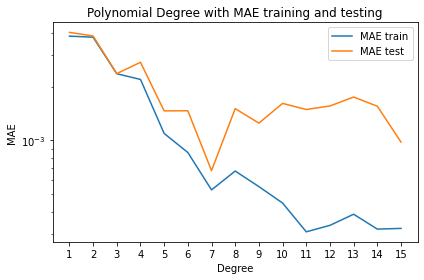

The optimal degree of polynomial for Longitude is 7


In [431]:
poly_int_together()

In [406]:
def stand(df):
    scaler = preprocessing.StandardScaler().fit(df)
    df_scale=scaler.transform(df)
    return df_scale
y_train=pd.DataFrame(stand(y_train),columns=['LAT','LON'])
y_test=pd.DataFrame(stand(y_test),columns=['LAT','LON'])


Regression on degree= 1
Regression on degree= 2
Regression on degree= 3
Regression on degree= 4
Regression on degree= 5
Regression on degree= 6
Regression on degree= 7
Regression on degree= 8
Regression on degree= 9
Regression on degree= 10
Regression on degree= 11
Regression on degree= 12
Regression on degree= 13
Regression on degree= 14
Regression on degree= 15


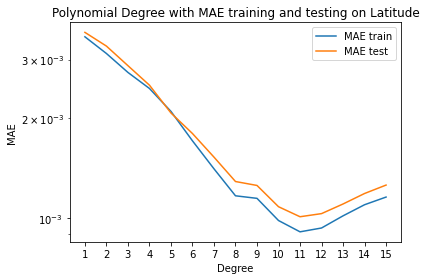

The optimal degree of polynomial for Latitude is 11


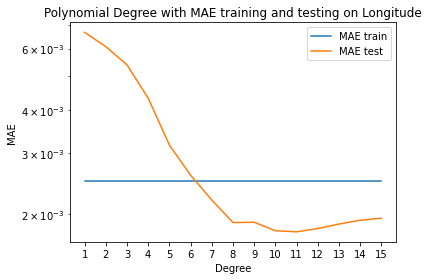

The optimal degree of polynomial for Longitude is 11


In [432]:
# Johnathan's parametric model LAT=f(t); LON=g(t)
poly_int_sep(X_train,X_test)


In [436]:
# degree_opt=int(input('Optimal polynomial degree'))
degree_opt=11
# X_train=np.array(X_train['BaseDateTime']).reshape(-1,1)
# X_test=np.array(X_test['BaseDateTime']).reshape(-1,1)


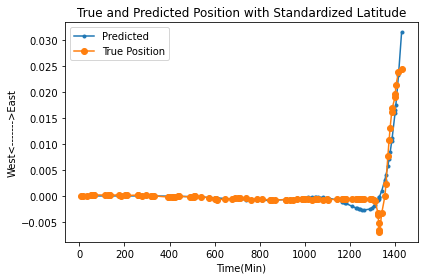

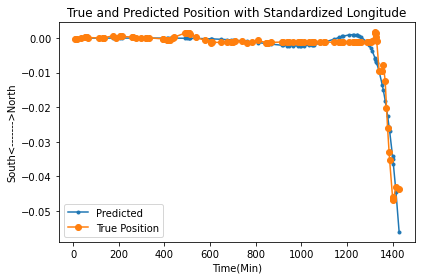

In [437]:
model = make_pipeline(PolynomialFeatures(degree_opt),LinearRegression())
model=model.fit(np.array(X_train['BaseDateTime']).reshape(-1,1), y_train['LAT'])
y_pred=model.predict(np.array(X_test['BaseDateTime']).reshape(-1,1))
model.named_steps['linearregression'].coef_
def f(x):
    poly=PolynomialFeatures(degree_opt)
    X=poly.fit_transform(x)
    coef=model.named_steps['linearregression'].coef_
    y=X @ coef.reshape(-1,1)   
    return y
fig, ax=plt.subplots()
ax.plot(np.array(X_test['BaseDateTime']).reshape(-1,1),f(np.array(X_test['BaseDateTime']).reshape(-1,1)).reshape(-1,1),'.-')
ax.plot(np.array(X_test['BaseDateTime']).reshape(-1,1),y_test['LAT'],'o-')
ax.set_xlabel('Time(Min)')
ax.set_ylabel('West<------->East')
ax.legend(["Predicted",'True Position'],loc='best')
ax.set(title='True and Predicted Position with Standardized Latitude')
fig.tight_layout()
model = make_pipeline(PolynomialFeatures(11),LinearRegression())
model=model.fit(np.array(X_train['BaseDateTime']).reshape(-1,1), y_train['LON'])
y_pred=model.predict(np.array(X_test['BaseDateTime']).reshape(-1,1))
def f(x):
    poly=PolynomialFeatures(11)
    X=poly.fit_transform(x)
    coef=model.named_steps['linearregression'].coef_
    y=X @ coef.reshape(-1,1)   
    return y
fig, ax=plt.subplots()
ax.plot(np.array(X_test['BaseDateTime']).reshape(-1,1),f(np.array(X_test['BaseDateTime']).reshape(-1,1)).reshape(-1,1),'.-')
ax.plot(np.array(X_test['BaseDateTime']).reshape(-1,1),y_test['LON'],'o-')
ax.set_xlabel('Time(Min)')
ax.set_ylabel('South<------->North')
ax.legend(["Predicted",'True Position'],loc='best')
ax.set(title='True and Predicted Position with Standardized Longitude')
fig.tight_layout()
plt.show()


In [286]:
def f(x):
    poly=PolynomialFeatures(degree_opt)
    X=poly.fit_transform(x)
    coef=model.named_steps['linearregression'].coef_
    y=X @ coef.reshape(-1,1)   
    return y

In [368]:
y_train=pd.DataFrame(stand(y_train),columns=['LAT','LON'])

In [390]:
y_train

,LAT,LON
0,0.428681,0.060197
1,0.428681,0.060197
2,-1.093649,1.751935
3,-0.180251,0.060197
4,-0.180251,0.398544
...,...,...
321,0.428681,0.398544
322,0.428681,0.398544
323,-0.180251,-0.616498
324,0.733147,-1.631541


In [391]:
y_test

,LAT,LON
0,-1.083315,-0.505931
1,0.443174,0.117269
2,-1.083315,0.428869
3,-0.320070,0.117269
4,0.443174,0.117269
...,...,...
88,-1.083315,-1.440732
89,-0.320070,0.117269
90,-2.228181,-1.440732
91,-1.083315,-0.505931
